In [1]:
%matplotlib widget
import numpy as np
import math
import cmath
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits import mplot3d

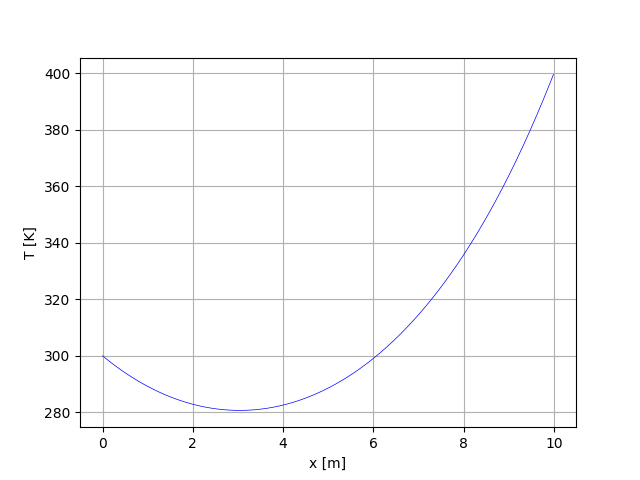

In [2]:
# Heated Rod: steady-state temperature distribution for a long and thin heated rod
# placed in between two walls with constant temperatures (conduction and convection)

# Parameters' values:
Ta = 300 # K
Tb = 400 # K
h_bulk = 0.05 # m^(-2)
Tinf = 200 # K
lbd = math.sqrt(h_bulk)
L = 10 # m

# Integration coefficients:
A = ( (Ta - Tinf) * math.exp(-lbd*L) - (Tb - Tinf) ) / ( math.exp(-lbd*L) - math.exp(lbd*L) )
B = ( (Tb - Tinf) - (Ta - Tinf) * math.exp(lbd*L) ) / ( math.exp(-lbd*L) - math.exp(lbd*L) )

# Discretization of the rod's length:
xe = np.arange(0, L, 0.01)

# Temperature profile: we use numpy.exp for vectorization
Te = Tinf + A * np.exp(lbd*xe) + B * np.exp(-lbd*xe)

# Plot of analytical results for Temperature versus Length:
fig1 = plt.figure()
plt.plot(xe, Te, color = 'blue', linewidth = 0.5)
plt.xlabel('x [m]')
plt.ylabel('T [K]')
plt.grid(visible = True)
plt.show()

In [3]:
def ode_sys_adaptive(dydt, trange, y0, h, *args):
    """Solver for Systems of ODEs via Adaptive Runge-Kutta Sencond- and Third-Orders.
    
    dydt: function that evaluates the system of dy/dt
    trange: numpy array with the integration limits
    y0: numpy array with the initial conditions
    h: step size
    args: additional parameters required by dydt
    """
    
    absTol = 1e-6
    relTol = 1e-3
    
    hi = h
    ti = trange[0]
    tf = trange[-1]
    t = np.arange(ti, tf, h)
    y = np.zeros( (t.size, y0.size) )
    y[0, :] = y0
    E = np.zeros( (t.size, y0.size) )
    
    i = 0
    k1 = dydt(t[i], y[i, :], *args)
    while i < t.size - 1:
        ymid = y[i, :] + k1 * hi / 2
        
        k2 = dydt(t[i] + hi / 2, ymid, *args)
        y34 = y[i, :] + (3/4) * k2 * hi
        
        k3 = dydt(t[i] + (3/4) * hi, y34, *args)
        
        phi = (2 * k1 + 3 * k2 + 4 * k3) / 9
        
        y[i + 1, :] = y[i, :] + phi * hi
        
        k4 = dydt(t[i + 1], y[i + 1, :], *args)
        
        E[i + 1, :] = (1/72) * (-5 * k1 + 6 * k2 + 8 * k3 - 9 * k4) * hi
        
        if np.all( (relTol * np.abs(y[i + 1, :])) >= absTol ):
            if np.any( E[i + 1, :] <= relTol * np.abs(y[i + 1, :]) ):
                k1 = k4
                hi = h
                i += 1
            else:
                hi /= 10
        else:
            if np.any( E[i + 1, :] <= absTol ):
                k1 = k4
                hi = h
                i += 1
            else:
                hi /= 10
                
        if t[i] == tf:
            break
            
    return t, y

In [4]:
def rod(x, y, h_bulk, Tinf):
    """Heated Rod Subjected to Conduction and Convection: System of First-Order ODEs."""
    
    dy = np.zeros(y.size)
    
    dy[0] = y[1]
    dy[1] = -h_bulk * (Tinf - y[0])
    
    return dy

Predicted Boundary Condition Tb1 = 561.8697 [K]
Predicted Boundary Condition Tb2 = 460.7964 [K]
Predicted Boundary Condition Tb3 = 400.0000 [K]


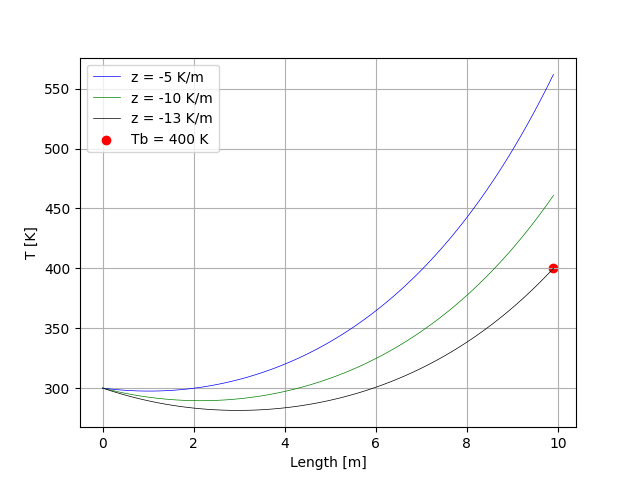

In [5]:
# Shooting Method for solving the Dirichlet boundary-value problem of the heated rod's
# linear second-order ODE

# Integration range:
trange = np.array( [0, 10])

# Parameters
h_bulk = 0.05
Tinf = 200

# Boundary conditions:
Ta = 300
Tb = 400

# Step size:
h = 0.1

# Initial conditions to approximate the Boundary conditions:
za = -5 # K/m; first guess
y0 = np.array([Ta, za]) # [T, z]

# Solve the system of ODEs via Adaptive second- third-order RK
# We do two preliminary passes so to get an interpolated prediction for the initial value of the slope: z(0)

# First pass:
xa, ya = ode_sys_adaptive(rod, trange, y0, h, h_bulk, Tinf)
print("Predicted Boundary Condition Tb1 = {:.4f} [K]".format(ya[-1, 0]))

# Second pass:
zb = -10 # K/m; second guess
y0 = np.array([Ta, zb]) # [T, z]
xb, yb = ode_sys_adaptive(rod, trange, y0, h, h_bulk, Tinf)
print("Predicted Boundary Condition Tb2 = {:.4f} [K]".format(yb[-1, 0]))

# Linear interpolation for the third and last guess:
zc = za + ( ( zb - za ) / ( yb[-1, 0] - ya[-1, 0] ) ) * ( Tb - ya[-1, 0] )

# Third pass with interpolated guess:
y0 = np.array([Ta, zc]) # [T, z]
xc, yc = ode_sys_adaptive(rod, trange, y0, h, h_bulk, Tinf)
print("Predicted Boundary Condition Tb3 = {:.4f} [K]".format(yc[-1, 0]))

# Plot results for Temperature versus Length:
fig2 = plt.figure()
plt.plot(xa, ya[:, 0], color = 'blue', linewidth = 0.5, label = 'z = -5 K/m')
plt.plot(xb, yb[:, 0], color = 'green', linewidth = 0.5, label = 'z = -10 K/m')
plt.plot(xc, yc[:, 0], color = 'black', linewidth = 0.5, label = 'z = -13 K/m')
plt.scatter(xa[-1], Tb, color = 'red', label = 'Tb = 400 K')
plt.xlabel('Length [m]')
plt.ylabel('T [K]')
plt.legend()
plt.grid(visible = True)
plt.show()

In [6]:
ydata = xa[:]
ydata

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1,
       5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4,
       6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7,
       7.8, 7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. ,
       9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])

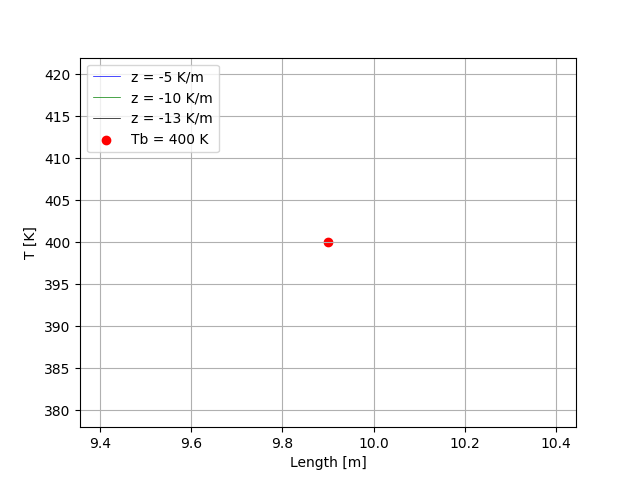

Button(description='pause', style=ButtonStyle())

Button(description='resume', style=ButtonStyle())

In [10]:
from matplotlib.animation import FuncAnimation
figy, ax = plt.subplots()

xdata1, ydata1 = [], []
xdata2, ydata2 = [], []
xdata3, ydata3 = [], []

ln1, = plt.plot([], [], color = 'blue', linewidth = 0.5, label = 'z = -5 K/m') 
ln2, = plt.plot([], [], color = 'green', linewidth = 0.5, label = 'z = -10 K/m')
ln3, = plt.plot([], [], color = 'black', linewidth = 0.5, label = 'z = -13 K/m')

def init():
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 600)
    return ln1, ln2, ln3

def update(frame):
    xdata1 = []
    ydata1 = []
    xdata1.append(xa[0:frame])
    ydata1.append(ya[0:frame, 0])
    ln1.set_data(xdata1, ydata1)
    
    xdata2 = []
    ydata2 = []
    xdata2.append(xb[0:frame])
    ydata2.append(yb[0:frame, 0])
    ln2.set_data(xdata2, ydata2)
    
    xdata3 = []
    ydata3 = []
    xdata3.append(xc[0:frame])
    ydata3.append(yc[0:frame, 0])
    ln3.set_data(xdata3, ydata3)
        
    return ln1, ln2, ln3

ani = FuncAnimation(figy, update, frames = 100, interval = 20, init_func = init, blit = True)

plt.scatter(xa[-1], Tb, color = 'red', label = 'Tb = 400 K')
plt.xlabel('Length [m]')
plt.ylabel('T [K]')
plt.legend()
plt.legend(loc = 'upper left')
plt.grid(visible = True)

plt.show()



import ipywidgets as widgets
btn_pause = widgets.Button(description = 'pause')
btn_pause.on_click(lambda b: ani.pause())
display(btn_pause)

btn_resume = widgets.Button(description = 'resume')
btn_resume.on_click(lambda b: ani.resume())
display(btn_resume)

In [ ]:
display()

In [ ]:
def modified_secant(f, xi, delta, es = 1e-4, maxit = 50, *args):
    """Root Finding via Modified Secant Method.
    
    f: target function f(x) to find the root
    xi: initial guess
    delta: step size
    es: target percentage relative error
    maxit: max number of iterations
    args: additinal parameters required by f(x)
    """
    
    xi_new = 0
    i = 0 # Number of iterations
    ea = 100 # Percentage relative error
    while ea >= es or i <= maxit:
        xi_new = xi - ( delta * xi * f(xi, *args) ) / ( f(xi + delta * xi, *args) - f(xi, *args) )
        i += 1
        
        if xi_new:
            ea = abs( (xi_new - xi) / xi_new ) * 100
        
        xi = xi_new
        
    return xi_new, ea, i

In [ ]:
def rod_rcc(x, y):
    """Heated Rod Subject to Radiaton, Conduction, and Convection: Linear ODE System.
    
    x: numpy array with independent variable values
    y: numpy array with dependent variables values
    """
    
    h_bulk = 0.05 # m^(-2)
    Tinf = 200 # K
    sigma = 2.7e-9 # K^(-3)*m^(-2)
    
    dy = np.zeros(y.size)
    dy[0] = y[1]
    dy[1] = -h_bulk * (Tinf - y[0]) - sigma * (Tinf**4 - y[0]**4)
    
    return dy    

In [ ]:
def residual(za, trange, T0, Tb, step_size):
    """Residual Estimation for the Heated Rod Subject to Radiation, Conduction, and Convection.
       The ODE system is solved via Adaptive RK23.
       
       za: initial for temperature gradient
       trange: interval of integration
       T0, Tb: temperatures biundary conditions
       step_size: initial step size for the adaptive RK23 method
       """
    
    y0 = np.array([To, za])
    x, y = ode_sys_adaptive(rod_rcc, trange, y0, step_size)
    
    return y[-1, 0] - Tb

In [ ]:
# Shooting Method for solving the Dirichlet boundary-value problem of the heated rod's
# non-linear second-order ODE: rod subject to conduction, convection, and radiation.

# Integration range:
trange = np.array([0, 10])

# Rod's parameters:
h_bulk = 0.05 # m^(-2)
Tinf = 200 # K
sigma = 2.7e-9 # K^(-3)*m^(-2)

# Initial step size:
step_size = 0.25 # meters

# Dirichlet boundary conditions:
To = 300 # K
Tb = 400 # K

# Initial conditions to approximate the Boundary conditions:
za = -50 # K/m

# Parameters for the root finding step:
delta = 0.01
es = 1e-3
maxit = 50

# Use the Modified Secant Method to find the temperature gradient at the boundary:
root, ea, it = modified_secant(residual, za, delta, es, maxit, trange, To, Tb, step_size)

# Get the temperature profile using the initial conditions based on the
# boundary conditions estimated in the previous step:
y0 = np.array([300, root]) # [T, z]
xnls, ynls = ode_sys_adaptive(rod_rcc, trange, y0, step_size)

# Plot the results:
fig3 = plt.figure()
plt.scatter(xnls[-1], Tb, color = 'red', label = 'Tb = 400 K')
plt.plot(xnls, ynls[:, 0], color = 'blue', linewidth = 0.5, label = 'Nonlinear Solution: Shooting Method')
plt.plot(xc, yc[:, 0], color = 'black', linewidth = 0.5, label = 'Linear Solution: Shooting Method')
plt.xlabel("Rod's Length [m]")
plt.ylabel("T [K]")
plt.legend()
plt.grid(visible = True)
plt.show()

In [ ]:
# Finitie-Difference Method for determining the temperature profile of the
# heated rod subject to conduction and convection (linear ODEs)

# Dirichlet boundary conditions:
T0 = 300
Tb = 400

# Rod's parameters and environmental conditions: 
Tinf = 200
L = 10
h_bulk = 0.05

# Step size for discretization of rod's length
Dx = 0.1 # Use Dx = 0.1 (or 0.01) with 100 (or 1000) nodes to converge to exact solution

# Number of nodes for the discretization:
nodes = 100

T = np.zeros(nodes)
A = np.zeros([nodes, nodes])
B = np.zeros(nodes)

for i in range(nodes):
    if not i:
        A[i, i] = 2 + h_bulk * Dx**2
        A[i, i + 1] = -1
        B[i] = T0 + h_bulk * Tinf * Dx**2
    elif i == nodes - 1:
        A[i, i - 1] = -1
        A[i, i] = 2 + h_bulk * Dx**2
        B[i] = Tb + h_bulk * Tinf * Dx**2
    else:
        A[i, i - 1] = -1
        A[i, i] = 2 + h_bulk * Dx**2
        A[i, i + 1] = -1
        B[i] = h_bulk * Tinf * Dx**2

T = np.linalg.solve(A, B)

T = np.insert(T, 0, T0)
T = np.append(T, Tb)
x = np.linspace(0, L, nodes + 2)

# Plot the results:
fig4 = plt.figure()
plt.plot(x, T, color = 'blue', linewidth = 0.5, marker = 'o', markersize = 2, label = 'Finite-Difference Method')
plt.plot(xc, yc[:, 0], color = 'black', linewidth = 0.5, label = 'Shooting Method')
plt.plot(xe, Te, color = 'red', linewidth = 0.5, label = 'Analytical Solutions')
plt.xlabel("Rod's Length [m]")
plt.ylabel("T [K]")
plt.legend()
plt.grid(visible = True)
plt.show()

In [ ]:
# Finite-Difference Method for Nonlinear ODE Systems
# Heated Rod case

# Parameters:
h_bulk = 0.05 # m^(-2)
Tinf = 200 # K
Tb = 400 # K
sigma = 2.7e-9 # K^(-3)*m^(-2)
L = 10 # m
Dx = 2 # m

# Boundary conditions:
T0 = 300 # K
Tb = 400 # K

# Number of interior nodes:
nodes = 4

# Tolerance:
tol = 1e-3

# Maximum number of iterations
maxiter = 100

T = np.zeros(nodes + 2)
T[0] = T0
T[-1] = Tb

Told = np.zeros(T.size)

# Relative percentage error for the interior nodes:
eps = 100 * np.ones(nodes)

j = 0 # number of interations
while j < maxiter:
    for i in range(1, T.size - 1): # Only for interior nodes
        T[i] = (h_bulk * Tinf * Dx**2 + sigma * Dx**2 * (Tinf**4 - T[i]**4) + T[i - 1] + T[i + 1]) / (2 + h_bulk * Dx**2)
        eps[i - 1] = np.abs( (T[i] - Told[i]) / T[i] ) * 100
        Told[i] = T[i]
    
    if np.all(eps[:] < tol): # tolerance criterion for interior nodes only
        break
    
    j += 1

# Print results:
for i in range(T.size):
    if i == 0 or i == T.size - 1: # first and last nodes: boundary conditions
        print("T[{:1d}] = {:.3f}K".format(i, T[i]))
    else:
        print("T[{:1d}] = {:.3f}K with error = {:.6f}%".format(i, T[i], eps[i - 1]))

# Generate x-axis values for plotting:
x = np.arange(0, L + Dx, Dx)

# Plot the results:
fig5 = plt.figure()
plt.plot(x, T, color = 'red', linewidth = 0.5, marker = 'o', markersize = 5, label = 'Finite-Difference Method')
plt.plot(xnls, ynls[:, 0], color = 'blue', linewidth = 0.5, label = 'Shooting Method')
plt.xlabel("Rod's Length [m]")
plt.ylabel("T [K]")
plt.legend()
plt.grid(visible = True)
plt.show()